# Exercise Flextopo 

In this exercise you are asked to create a Flextopo model in a seperate Python file which will be imported here. This notebook can then be used to run the model, the notebook also imports the relevant packages needed to run it on eWaterCycle.

In this folder you can find a file called flextopo_bmi.py. Open that file and look for the function called update, ie def update(self) -> None:. If you look closely you will see that this is the 'core' of Flextopo model. As you can see, most of the variables are set to zero, which is, of course, incorrect. Change this part as you learned in the HBV exercise, but make sure you use self.var instead of var for any variable. For example: self.Si = self.Si + self.P_dt. This way of coding is needed because we are creating a HBV class here that we can use later. (Remember your programming classes in MUDE and before).

Once you have added your code, save the file and run the notebook below. Read carefully, you will have to change some things yourself. The first part will create a hydrograph in which you can compare your calculated discharge with the reference discharge. In the second part, a test case is created which will check your model with a pre-defined parameter set and initial storages. Optionally, in the third part you can create a test case yourself.

Important: Anytime you edit the code in hbv_bmi.py, it is important to restart the kernel and re-run the cells, to make sure your changes are imported (in cell 3 below)

In [1]:
# General python

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from FLEXtopo import FLEXtopo
from datetime import datetime 
import warnings
warnings.filterwarnings('ignore')


## Load data

In the folder `wark_data` you can find data from the Wark region. In the cell below the data is loaded into arrays and plotted. 

In [2]:
DEM = np.genfromtxt('wark_data/dems.asc',  dtype=float, autostrip=True)
slope = np.genfromtxt('wark_data/Slope Layer.asc',  dtype=float, autostrip=True)
hand = np.genfromtxt('wark_data/hands.asc',  dtype=float, autostrip=True)
basin = np.genfromtxt('wark_data/basin.asc',  dtype=float, autostrip=True)

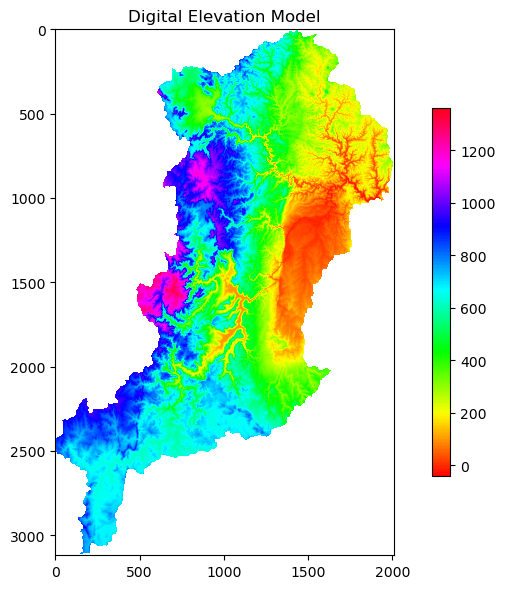

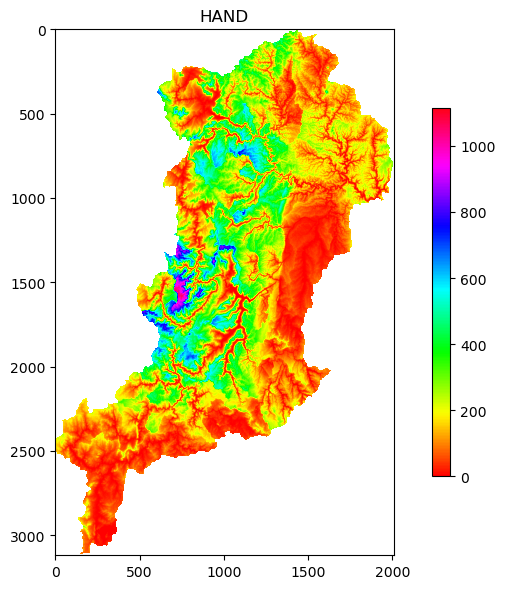

In [3]:
# Plot DEM
fig, ax = plt.subplots(figsize=(8,6))
ax.set_title('Digital Elevation Model')
DEM[DEM==-99999] = np.nan
im = ax.imshow(DEM, cmap='hsv')
fig.colorbar(im, ax=ax, shrink=0.7)
fig.tight_layout()

# plot HAN
fig, ax = plt.subplots(figsize=(8,6))
ax.set_title('HAND')
hand[hand==-9999] = np.nan
im = ax.imshow(hand, cmap='hsv')
fig.colorbar(im, ax=ax, shrink=0.7)
fig.tight_layout()

## Classification

Create classifications based on the `slope`, `hand` and `basin`.
If the slope is larger than 11, it is defined as a hillslope. For hand larger than 5 and slope smaller than 11, it is plateau. For hand smaller than or equal to 5 and slope smaller than or equal to 11, it is defined as wetland. 
Basin is defined for all indices larger than 0 in the basin array. 


Calculate the percentages of hillslope, wetland and plateau in the area. 

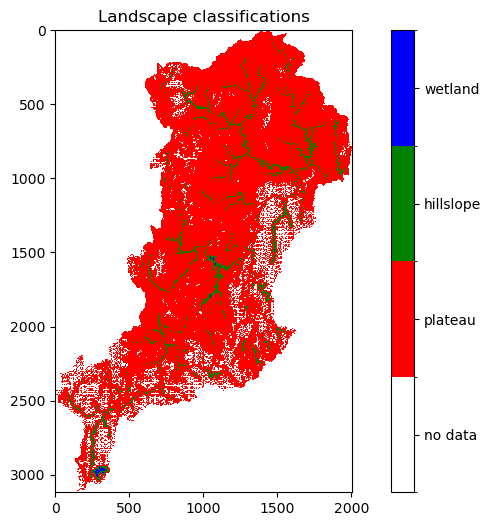

In [4]:
# Make landscape classification
hillslope = np.array(slope) >11
plateau = (np.array(hand) > 5) & (np.array(slope) <= 11)
wetland = (np.array(hand) <= 5) & (np.array(slope) <= 11)
basin = np.array(basin) > 0

hillslope_per = float(np.sum(hillslope))/float(np.sum(basin))
wetland_per = float(np.sum(wetland))/float(np.sum(basin))
plateau_per = float(np.sum(plateau))/float(np.sum(basin))

landscapes = np.zeros((3120,2007))
landscapes[plateau] = 1
landscapes[hillslope] = 2
landscapes[wetland] = 3

# Plot landscapes
cmap = mpl.colors.ListedColormap(['white', 'red', 'green', 'blue'])
bounds = [0,1,2,3,4]
labels = ['no data', 'plateau', 'hillslope', 'wetland']
norm = mpl.colors.BoundaryNorm(bounds, cmap.N, )

fig, ax = plt.subplots(figsize=(10,6))
ax.set_title('Landscape classifications')
im = ax.imshow(landscapes, cmap=cmap, norm=norm,)
# Create color bar
cbar = plt.colorbar(im, ticks=[0.5, 1.5, 2.5, 3.5])
cbar.set_ticklabels(labels)
plt.show()

#Apparently, these parameters were based on a catchment in Luxemburg, which has very different topography compared to our catchment in Australia. In the future,
#it should be changed to fit the catchment better. This is why the image looks so strange in the image below. Too many areas are classified as plateaus, and the lakes and rivers are most often
#classified as hillslopes, which is incorrect. 

## Define parameters

Load the forcing data from the text file in the `wark_data` folder. 
Define the parameters as you did before for the HBV model, now you need to define them for `Plateau`, `Hillslope` and `Wetland` areas. `Ks` and `Tlag` are defined for the whole catchment. 

In [5]:
# Assuming the text file has three columns: year, month, day
# Use pandas to read the text file
df = pd.read_csv('wark_data/forcingWark.txt', sep='\s+', header=None, names=['month', 'day', 'year', 'Qo', 'Prec', 'Etp'], dtype=float)

# Create a new column that combines the year, month, and day into a datetime object
df['date'] = pd.to_datetime(df[['day', 'month', 'year']])

forcing = df

In [6]:
                  #      Imax Ce Sumax beta Pmax    Kf  
ParPlateau   = np.array([3.2, 0.50, 17.40, 0.95, 1.76, 0.91])   
                  #      Imax Ce Sumax beta D     Kf  
ParHillslope = np.array([3.25, 0.50, 321.99, 0.99, 0.4, 0.97])
                  #      Imax Ce Sumax beta Cmax     Kf  
ParWetland   = np.array([9.94, 0.50, 53.25, 0.70, 0.65, 0.45])
              # Ks Tlag
ParCatchment = np.array([0.0281, 2.21])

# Landscape percentages
landscape_per = np.array([plateau_per, hillslope_per, wetland_per])

## Calculate the discharge 

Use the FLEXtopo model to calculate the discharge. Plot it together with the measured discharge.

Text(0, 0.5, 'Flow')

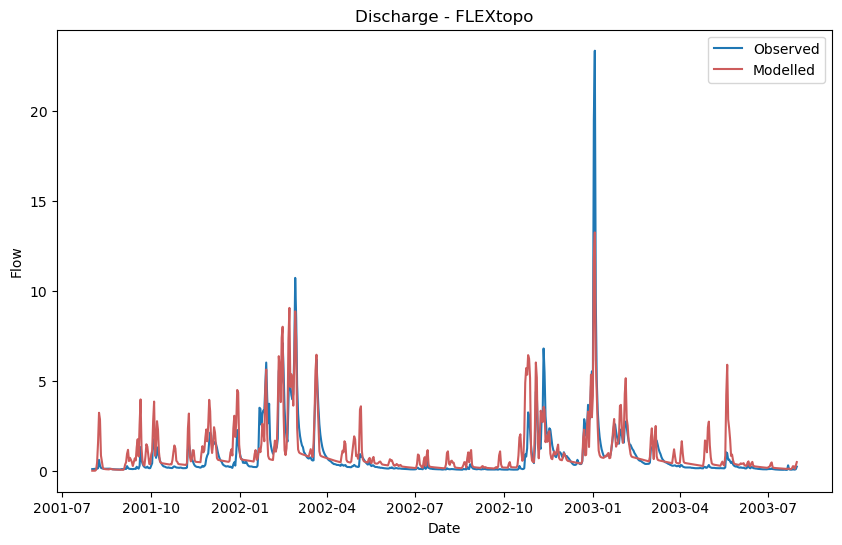

In [7]:
Qm = FLEXtopo(ParPlateau, ParHillslope, ParWetland, ParCatchment, forcing, landscape_per)
Qo = forcing['Qo']	

fig, ax = plt.subplots(figsize=(10,6))

ax.plot(df['date'], Qo, label='Observed')
ax.plot(df['date'], Qm, label='Modelled', color= 'indianred')
ax.legend()
ax.set_title('Discharge - FLEXtopo')

ax.set_xlabel('Date')
ax.set_ylabel('Flow')